# Heat map tool

## compute and save heatmaps

In [14]:
import seaborn as sn
import pandas as pd
import numpy as np
from tqdm import tqdm
import yaml

def print_hm(data, index, columns, vmin, vmax, title, selector=None, labels=["hidden size", "num. layers"]):
    if selector is not None:
        data_split = []
        for i in range(len(data[0][0])):
            data_split.append([])
            for j in range(len(data[0])):
                data_split[i].append([])
                for k in range(len(data)):
                    data_split[i][j].append(data[k][j][i])
        data = data_split[selector]

    df = pd.DataFrame(data, index=index, columns=columns)
    ax = sn.heatmap(df, annot=True, fmt=".4f", cmap="YlGnBu", vmin=vmin, vmax=vmax, cbar=False)
    ax.set_title(title)
    ax.figsize=(5,10)
    ax.set(xlabel=labels[0], ylabel=labels[1])
    ax.figure.savefig(f"heatmap/{title}.png", dpi=300)
    ax.figure.clf()

In [14]:
# get data from yaml
with open("heatmap_data.yaml", "r") as f:
    data = yaml.safe_load(f)

columns = ["256", "512", "1024"] #["16", "32", "64", "128", "256", "512", "1024"] # hidden_size 
index  = ["1", "2", "4"]#, "8", "16"]#, "16"] # n_layer
models = ["graph_gat"]# ["graph_GCN", "graph_gat", "graph_sage", "graph_gin"]
selector = 1 # 1: acc 
heads = [2, 4, 8]
x_type = "4ll"
raw=True

data = (
    data["data_cx"] if x_type == "c+x" else
    data["data_c"] if x_type == "c" else
    data["data_ll"] if x_type == "ll" else
    data["data_llc"] if x_type == "ll+c" else
    data["data_4ll"] if x_type == "4ll" else
    data["data_4llc"] if x_type == "4ll+c" else
    None
)

# get min max values
all_values = []
for test in data:
    for hidden_size in data[test]:
        for n_layer in hidden_size:
            all_values.append(n_layer[selector])
min = np.min(all_values)
max = np.max(all_values)
mean = np.mean(all_values)
median = np.median(all_values)
print(min, mean, median, max)
min = 0.83807
max = 0.89221

# get max btwn checkpoints
def get_max(model, head=None):
    data_split = [[[] for _ in range(len(columns))] for _ in range(len(index))]
    # populate
    for test in data:
        if (head is None and model in test) or (head is not None and model in test and str(head) in test):
            for i in range(len(index)):
                for c in range(len(columns)):
                    try:
                        data_split[i][c].append(data[test][c][i][selector])
                    except IndexError:
                        print(f"Error: {model} {head} {index[i]} {columns[c]}")
    # get max
    for i in range(len(index)):
        for c in range(len(columns)):
            try:
                data_split[i][c] = np.max(data_split[i][c])
            except ValueError:
                data_split[i][c] = 0
                print(f"Error: {model} {head} {index[i]} {columns[c]}")
    return data_split

if not raw:
    for model in tqdm(models):
        if model == "graph_gat":
            for h in heads:
                data_split = get_max(model, h)
                print_hm(data_split, index, columns, min, max, f"{x_type}_{model}_{h}")
        else:
            data_split = get_max(model)
            print_hm(data_split, index, columns, min, max, f"{x_type}_{model}")
else:
    for test in tqdm(data):
        print_hm(data[test], index, columns, min, max, f"{x_type}_{test}", selector)

0.82747 0.8683833333333333 0.86859 0.88624


100%|██████████| 12/12 [00:04<00:00,  2.64it/s]


<Figure size 640x480 with 0 Axes>

Notes:


c : 0.03262 0.7221019200000001 0.72215 0.85057
c+x : 0.00483 0.5954636 0.7085 0.84653
ll :  0.00483 0.7336465066666666 0.75733 0.88059
ll+c : 0.0 0.7418553333333333 0.76517 0.87952

4ll gat: 0.82747 0.8683833333333333 0.86859 0.88624
4ll sage: 0.84739 0.8723008333333335 0.87224 0.89194
4ll+c gat: 0.75527 0.8671287962962965 0.867685 0.88871
4ll+c sage: 0.84143 0.8723305555555556 0.87232 0.89221

\texttt{compute\_stats.py}

In [22]:
distance= [30, 40, 45, 50, 60]
models = ["a", "b", "c"]
min = 0.83807
max = 0.89221

data_1 = [0.88627, 0.89060, 0.89221, 0.89100, 0.89150]
data_2 = [0.88917, 0.88982, 0.89194, 0.89122, 0.89120]
data_3 = [0.87921, 0.88512, 0.88871, 0.88498, 0.87585]

print_hm([data_1, data_2, data_3], models, distance, min, max, "distance comparison heat map", labels=["distance", "models"])

<Figure size 640x480 with 0 Axes>

In [23]:
# input layers strat 1 model 1
layers = [0, 1, 2, 3]
hidden = [540, 1024]
min = 0.83807
max = 0.89221

data_1 = [0.89221, 0.88151, 0.88378, 0.88208]
data_2 = [0.89221, 0.88151, 0.88035, 0.88269]

print_hm([data_1, data_2], hidden, layers, min, max, "Input linear layers comparison heat map", labels=["layers", "hidden size"])

<Figure size 640x480 with 0 Axes>

In [20]:
# output layers strat 1 model 1
layers = [0, 1, 2, 3]
hidden = [7, 16]
min = 0.83807
max = 0.89221

data_1 = [0.89221, 0.88806, 0.88160, 0.88309]
data_2 = [0.89221, 0.88806, 0.88535, 0.88370]

print_hm([data_1, data_2], hidden, layers, min, max, "Output linear layers comparison heat map", labels=["layers", "hidden size"])

<Figure size 640x480 with 0 Axes>

In [24]:
# input layers strat 2 model 1
layers = [0, 1, 2, 3]
hidden = [540, 1024, 2048]
min = 0.83807
max = 0.89221

data_1 = [0.89221, 0.88149, 0.88199, 0.88536]
data_2 = [0.89221, 0.88149, 0.88226, 0.88657]
data_3 = [0.89221, 0.88149, 0.88039, 0.88449]

print_hm([data_1, data_2, data_3], hidden, layers, min, max, "Input linear layers (strat. 2, model a)", labels=["layers", "hidden size"])

# output layers strat 2 model 1
layers = [0, 1, 2, 3]
hidden = [7, 16, 32]
min = 0.83807
max = 0.89221

data_1 = [0.89221, 0.89032, 0.03262, 0.47463]
data_2 = [0.89221, 0.89032, 0.89051, 0.88750]
data_3 = [0.89221, 0.89032, 0.89036, 0.88879]

print_hm([data_1, data_2, data_3], hidden, layers, min, max, "Output linear layers (strat. 2, model a)", labels=["layers", "hidden size"])

<Figure size 640x480 with 0 Axes>

In [25]:
# input layers strat 2 model 2
layers = [0, 1, 2, 3]
hidden = [540, 1024, 2048]
min = 0.83807
max = 0.89221

data_1 = [0.89221, 0.88580, 0.88488, 0.88549]
data_2 = [0.89221, 0.88580, 0.88625, 0.88540]
data_3 = [0.89221, 0.88580, 0.88620, 0.88799]

print_hm([data_1, data_2, data_3], hidden, layers, min, max, "Input linear layers (strat. 2, model b)", labels=["layers", "hidden size"])

# output layers strat 2 model 1
layers = [0, 1, 2, 3]
hidden = [7, 16, 32]
min = 0.83807
max = 0.89221

data_1 = [0.8919, 0.88932, 0.88963, 0.87139]
data_2 = [0.8919, 0.88932, 0.88846, 0.89221]
data_3 = [0.8919, 0.88932, 0.88885, 0.89027]

print_hm([data_1, data_2, data_3], hidden, layers, min, max, "Output linear layers (strat. 2, model b)", labels=["layers", "hidden size"])

<Figure size 640x480 with 0 Axes>

## Bar plot creation

/tmp/ipykernel_10700/3676222467.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(metrics)


(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.]),
 [Text(-1.0, 0, ''),
  Text(0.0, 0, 'F1 d'),
  Text(1.0, 0, 'Acc type'),
  Text(2.0, 0, 'F1 Neutrophil'),
  Text(3.0, 0, 'F1 Epithelial'),
  Text(4.0, 0, 'F1 Lymphocyte'),
  Text(5.0, 0, 'F1 Plasma'),
  Text(6.0, 0, 'F1 Eosinophil'),
  Text(7.0, 0, 'F1 Connective'),
  Text(8.0, 0, '')])

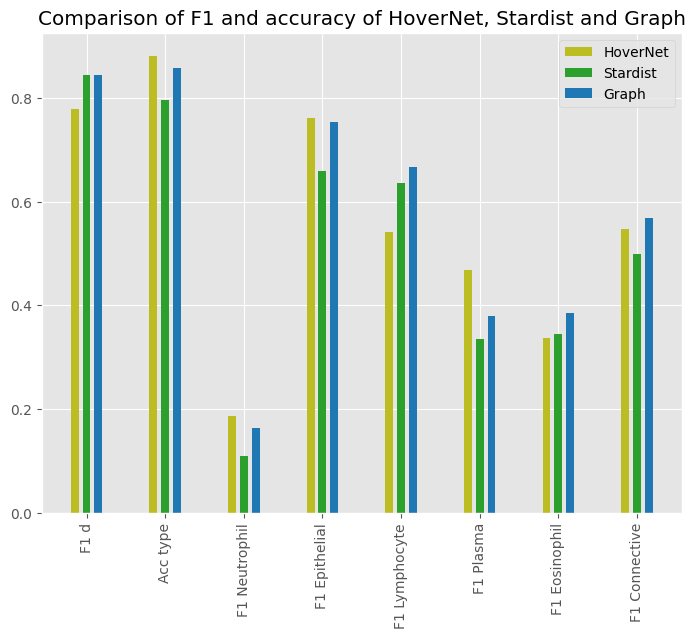

In [29]:
metrics = ["", "F1 d", "Acc type", "F1 Neutrophil", "F1 Epithelial", "F1 Lymphocyte", "F1 Plasma", "F1 Eosinophil", "F1 Connective"]
# Stardist = [0.84435, 0.79569, 0.11009, 0.66009, 0.63634, 0.33518, 0.34509, 0.49849]
# HoverNet = [0.77918, 0.88177, 0.18740, 0.76240, 0.54240, 0.46905, 0.33756, 0.54713]
# Graph = [0.84435, 0.85164, 0.14299, 0.74842, 0.6614, 0.38616, 0.36982, 0.5516]
HoverNet = [ 0.77918, 0.88177, 0.18740, 0.76240, 0.54240, 0.46905, 0.33756, 0.54713]
Stardist = [ 0.84428, 0.79568, 0.11009, 0.66010, 0.63627, 0.33515, 0.34509, 0.49834]
Graph = [ 0.84428,  0.85777,  0.16268,  0.75399,  0.66770, 0.37896, 0.38567, 0.56862]

import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')


X = np.arange(8)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X - 0.15, HoverNet, color = 'tab:olive', width = 0.1, label="HoverNet")
ax.bar(X, Stardist, color = 'tab:green', width = 0.1, label="Stardist")
ax.bar(X + 0.15, Graph, color = 'tab:blue', width = 0.1, label="Graph")
ax.set_title("Comparison of F1 and accuracy of HoverNet, Stardist and Graph")
ax.figsize=(5,10)
ax.set_xticklabels(metrics) 
ax.legend()
plt.xticks(rotation=90)
# ax.figure.savefig(f"final_acc_f1_comparison_bar.png", dpi=300)
# ax.figure.clf()

/tmp/ipykernel_10700/1382583996.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(metrics)


(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.]),
 [Text(-1.0, 0, ''),
  Text(0.0, 0, 'Binary PQ'),
  Text(1.0, 0, 'Neutrophil PQ'),
  Text(2.0, 0, 'Epithelial PQ'),
  Text(3.0, 0, 'Lymphocyte PQ'),
  Text(4.0, 0, 'Plasma PQ'),
  Text(5.0, 0, 'Eosinophil PQ'),
  Text(6.0, 0, 'Connective PQ'),
  Text(7.0, 0, '')])

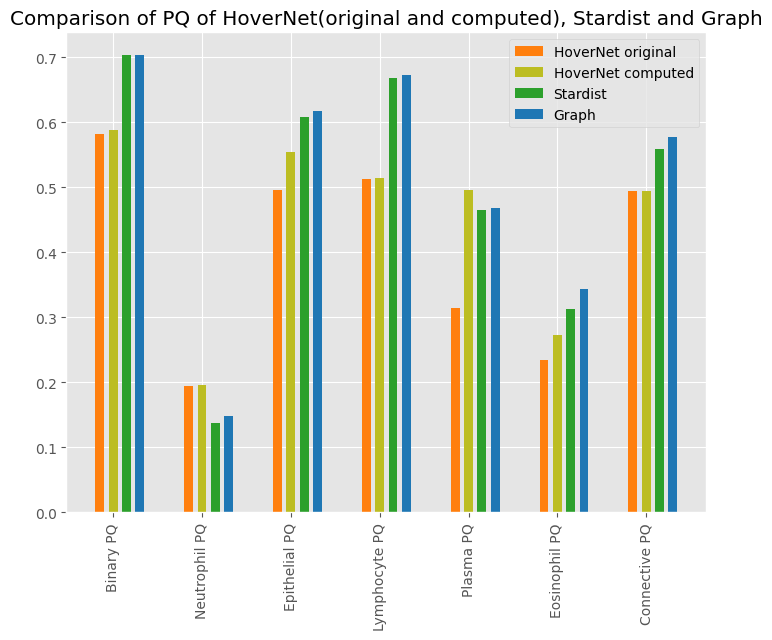

In [30]:
metrics = ["", "Binary PQ", "Neutrophil PQ", "Epithelial PQ", "Lymphocyte PQ", "Plasma PQ", "Eosinophil PQ", "Connective PQ"]
Stardist = [0.7029, 0.1372, 0.6082, 0.6675, 0.4652, 0.3129, 0.5587]
HoverNet_original = [0.582, 0.194, 0.495, 0.513, 0.314, 0.234, 0.494]
HoverNet_computed = [0.5884, 0.1958, 0.5541, 0.5136, 0.4952, 0.2735, 0.4948]
Graph = [0.7029, 0.1485, 0.6173, 0.6731, 0.4678, 0.3433, 0.5774]

import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

X = np.arange(7)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X - 0.15, HoverNet_original, color = 'tab:orange', width = 0.1, label="HoverNet original")
ax.bar(X - 0, HoverNet_computed, color = 'tab:olive', width = 0.1, label="HoverNet computed")
ax.bar(X + 0.15, Stardist, color = 'tab:green', width = 0.1, label="Stardist")
ax.bar(X + 0.3, Graph, color = 'tab:blue', width = 0.1, label="Graph")
ax.set_title("Comparison of PQ of HoverNet(original and computed), Stardist and Graph")
ax.figsize=(5,10)
ax.set_xticklabels(metrics) 
ax.legend()
plt.xticks(rotation=90)
# ax.figure.savefig(f"final_acc_f1_comparison_bar.png", dpi=300)
# ax.figure.clf()


## Line Chart creation

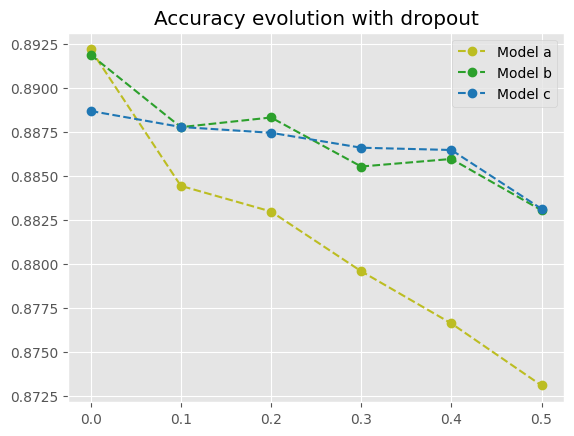

In [29]:
# dropout testing

dropout = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
model1 = [0.8922, 0.88444, 0.88298, 0.87958, 0.87661, 0.87308]
model2 = [0.8919, 0.88778, 0.88833, 0.88554, 0.88597, 0.88305]
model3 = [0.8887, 0.88779, 0.88746, 0.88661, 0.88648, 0.88313]

import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

fig = plt.figure()
ax = plt.axes()
ax.plot(dropout, model1, '--o', color = 'tab:olive', label="Model a")
ax.plot(dropout, model2, '--o', color = 'tab:green', label="Model b")
ax.plot(dropout, model3, '--o', color = 'tab:blue', label="Model c")


ax.set_title("Accuracy evolution with dropout")
ax.figsize=(5,10)
ax.legend()


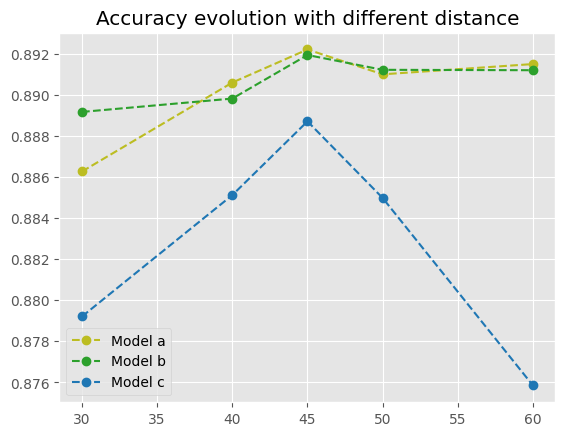

In [12]:
# distance testing

distance= [30, 40, 45, 50, 60]

model_a = [0.88627, 0.89060, 0.89221, 0.89100, 0.89150]
model_b = [0.88917, 0.88982, 0.89194, 0.89122, 0.89120]
model_c = [0.87921, 0.88512, 0.88871, 0.88498, 0.87585]

import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

fig = plt.figure()
ax = plt.axes()
ax.plot(distance, model_a, '--o', color = 'tab:olive', label="Model a")
ax.plot(distance, model_b, '--o', color = 'tab:green', label="Model b")
ax.plot(distance, model_c, '--o', color = 'tab:blue', label="Model c")

ax.set_title("Accuracy evolution with different distance")
ax.figsize=(10,20)
ax.legend()

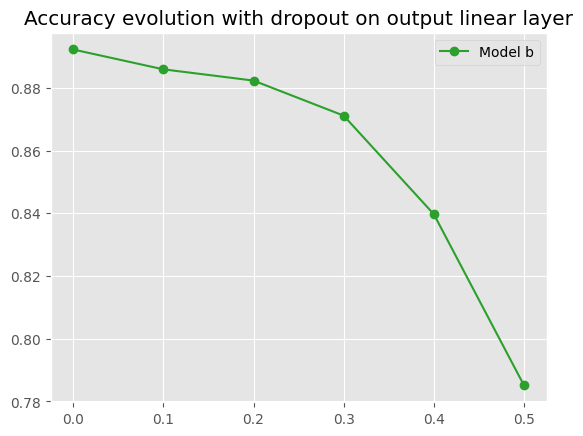

In [5]:
# final dropout testing

dropout = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
model2 = [0.89223, 0.88590, 0.88231, 0.87113, 0.83968, 0.78508]
neutrophil = [0.37229, 0.37157, 0.35456, 0.32749, 0.28526, 0.22577]
epithelial = [0.75050, 0.74720, 0.74238, 0.73671, 0.71721, 0.67962]
lymphocyte = [0.54709, 0.52824, 0.52780, 0.51277, 0.46615, 0.41643]
plasma = [0.26323, 0.27148, 0.25894, 0.25768, 0.23302, 0.17861]
eosinophil = [0.24746, 0.23625, 0.23970, 0.19092, 0.14482, 0.10338]
connective = [0.65026, 0.64868, 0.63628, 0.63033, 0.59828, 0.54749]


import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

fig = plt.figure()
ax = plt.axes()
ax.plot(dropout, model2, '-o', color = 'tab:green', label="Model b")



ax.set_title("Accuracy evolution with dropout on output linear layer")
ax.figsize=(5,10)
ax.legend()


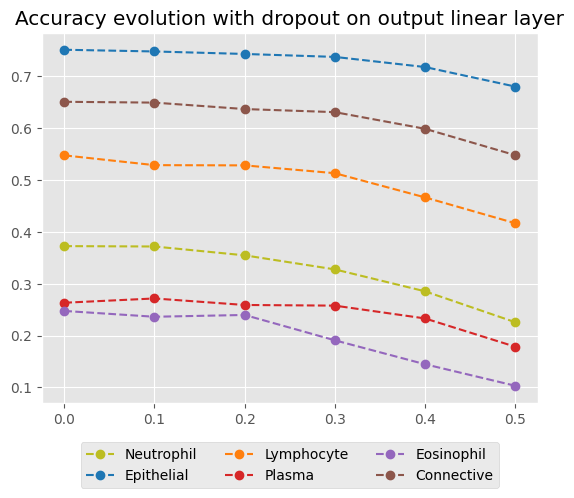

In [27]:
 
plt.style.use('ggplot')

fig = plt.figure()
ax = plt.axes()
ax.plot(dropout, neutrophil, '--o', color = 'tab:olive', label="Neutrophil")
ax.plot(dropout, epithelial, '--o', color = 'tab:blue', label="Epithelial")
ax.plot(dropout, lymphocyte, '--o', color = 'tab:orange', label="Lymphocyte")
ax.plot(dropout, plasma, '--o', color = 'tab:red', label="Plasma")
ax.plot(dropout, eosinophil, '--o', color = 'tab:purple', label="Eosinophil")
ax.plot(dropout, connective, '--o', color = 'tab:brown', label="Connective")



ax.set_title("Accuracy evolution with dropout on output linear layer")
ax.figsize=(5,10)
ax.legend(loc='lower center',bbox_to_anchor=(0.25, -0.25, 0.5, 0.5), ncol = 3)